# Experiment no.13 \[pilot\]

# . Imports

In [1]:
# torch family
import torch
from torch.utils.data import DataLoader, Subset, random_split

# torchvision family
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2 # G. model
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_320_fpn # C. model
from torchvision.ops import nms

# COCO family
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# utilities
import os
import sys
import numpy as np
import matplotlib.pyplot as plt # Visualization
from PIL import Image, ImageDraw # Visualization
import json # Result management
import preliminary.utils as utils
sys.path.append(f'/home/hwkang/jupyter/root/experiment/experiment-13/preliminary')
import preliminary.engine as engine

# Stochastic perturbation
sys.path.append('/home/hwkang/jupyter/root/')
from utility.synthesize import generate_one_noisy_image
from utility.preprocess import get_subset

# . Constants

In [2]:
# Paths
# Dataset
path_root_coco = '/home/hwkang/jupyter/root/dataset/COCO2017/'
path_train = os.path.join(path_root_coco, 'train2017')
path_valid = os.path.join(path_root_coco, 'val2017')
path_ann = os.path.join(path_root_coco, 'annotations')
path_file_ann_train = os.path.join(path_ann, 'instances_train2017.json')
path_file_ann_valid = os.path.join(path_ann, 'instances_val2017.json')

# . Data

## .. Dataset

### ... Custom dataset declaration

In [3]:
class CustomCocoDetection(torch.utils.data.Dataset):
    def __init__(self, image_dir, ann_file, transform=None):
        self.root = image_dir
        self.transform = transform
        self.coco = COCO(ann_file)
        self.ids = list(self.coco.imgs.keys())

    def __getitem__(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        path = self.coco.loadImgs(img_id)[0]['file_name']

        img = Image.open(os.path.join(self.root, path)).convert('RGB')

        image_id = torch.tensor([img_id])
        labels = [] # category_id 
        boxes = []
        #areas = []
        #iscrowds = []

        for ann in anns:
            #bbox_original = ann['bbox'] # CHECK
            bbox = torch.tensor(ann['bbox'], dtype=torch.float32)
            #bbox_before = bbox.clone() # CHECK
            bbox[2:4] += bbox[0:2] # Convert format XYWH to XYXY

            # If W and H are lesser equal than X_min and Y_min, then add tiny value
            # 만약 W와 H가 offset(x,y)보다 작거나 같다면, 이 bbox 라벨에 아주 작은 값을 추가
            if( bbox[0] >= bbox[2] or bbox[1] >= bbox[3] ):
                if( bbox[0] >= bbox[2] ):
                    bbox[2] += 0.1
                if( bbox[1] >= bbox[3] ):
                    bbox[3] += 0.1
                #print(f'from_coco: {bbox_original}\nbefore_convert: {bbox_before}\nafter_convert: {bbox}\n')
            
            labels.append(ann['category_id'])
            boxes.append(bbox)
            #areas.append(ann['areas'])
            #iscrowds.append(ann['iscrowd']

        # If it is not a background image which label is zero('0')
        # 배경(background) 이미지가 아닌 경우
        if len(boxes) > 0:
            labels = torch.as_tensor(labels, dtype=torch.int64)
            #boxes = torch.as_tensor(boxes, dtype=torch.float32)
            boxes = torch.stack(boxes)
        
        # Otherwise, that is background image
        # 배경 이미지인 경우
        else:
            labels = torch.zeros((0,), dtype=torch.int64)
            boxes = torch.zeros((0, 4), dtype=torch.float32)

        if self.transform is not None:
            img = self.transform(img)

        # image_id: metadata
        # labels: training, evaluation 
        # boxes: training, evaluation
        # area: 'not in use' (LASTEST Upd.: 24-08-09 16:23)
        # iscrowd: 'not in use' (LATEST Upd.: 24-08-09 16:23)
        target = {
            'image_id': image_id,
            'labels': labels,
            'boxes': boxes
                 }

        return img, target

    def __len__(self):
        return len(self.ids)

In [4]:
class PredictedLabelDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, ann_file, results, transform=None):
        self.root = image_dir
        self.coco = COCO(ann_file)
        """
        results contains ...
        [image_id]: int
        [category_id]: int
        [bbox]: float
        [score]: float
        """
        self.results = results
        self.ids = list({item['image_id'] for item in results}) # results에 있는 모든 image_id 리스트
        self.transform = transform

    def __getitem__(self, index):
        img_id = self.ids[index]

        # 실제 이미지 로딩
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        path = self.coco.loadImgs(img_id)[0]['file_name']
        img = Image.open(os.path.join(self.root, path)).convert('RGB')

        image_id = torch.tensor([img_id])
        labels = [] # category_id 
        boxes = []
        areas = []
        iscrowds = []

        filtered_dicts = [d for d in self.results if d.get('image_id') == img_id]

        for d in filtered_dicts:
            bbox = torch.tensor(d['bbox'], dtype=torch.float32)
            #bbox = np.array(d['bbox'])
            bbox[2:4] += bbox[0:2] # Convert XYWH to XYXY

            if( bbox[0] >= bbox[2] or bbox[1] >= bbox[3] ):
                if( bbox[0] >= bbox[2] ):
                    bbox[2] += 0.1
                if( bbox[1] >= bbox[3] ):
                    bbox[3] += 0.1
                    
            labels.append(d['category_id'])
            boxes.append(bbox)

        #boxes = np.array(boxes)

        # If it is not a background image which label is zero('0')
        # 배경(background) 이미지가 아닌 경우
        if len(boxes) > 0:
            labels = torch.as_tensor(labels, dtype=torch.int64)
            #boxes = torch.as_tensor(boxes, dtype=torch.float32)
            boxes = torch.stack(boxes)
        
        # Otherwise, that is background image
        # 배경 이미지인 경우
        else:
            labels = torch.zeros((0,), dtype=torch.int64)
            boxes = torch.zeros((0, 4), dtype=torch.float32)

        if self.transform is not None:
            img = self.transform(img)

        # image_id: metadata
        # labels: training, evaluation 
        # boxes: training, evaluation
        # area: 'not in use' (LASTEST Upd.: 24-08-09 16:23)
        # iscrowd: 'not in use' (LATEST Upd.: 24-08-09 16:23)
        target = {
            'image_id': image_id,
            'labels': labels,
            'boxes': boxes,
                 }

        return img, target

    def __len__(self):
        return len(self.ids)

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

### ... Dataset instances

In [6]:
# Training
train_dataset = CustomCocoDetection(path_train, path_file_ann_train, transform)

# Split training dataset w. ratio '8:2'
# 실제 훈련 데이터 9, 검증용 데이터 1로 기존 훈련용 데이터 분할
dataset_size = len(train_dataset)
train_size = int(0.8 * dataset_size)
valid_size = dataset_size - train_size

# Split Training
# Split Validation
split_train_dataset, split_valid_dataset = random_split(train_dataset, [train_size, valid_size])

loading annotations into memory...
Done (t=10.28s)
creating index...
index created!


In [7]:
# Sample datasets '80%' to '10%' x 8 
# Divide 'Split Training' to 'Sample Training'
total_length = len(split_train_dataset)
base_length = total_length // 8
split_lengths = [base_length] * 8

for i in range(total_length % 8):
    split_lengths[i] += 1

sample_datasets = random_split(split_train_dataset, split_lengths)

In [8]:
# Test
# NOTE: 원래는 검증용 데이터로 사용되어야 하나, 테스트 데이터가 없어 이 데이터셋을 테스트용으로 사용
test_dataset = CustomCocoDetection(path_valid, path_file_ann_valid, transform)

loading annotations into memory...
Done (t=1.17s)
creating index...
index created!


## .. DataLoader

In [9]:
# Create DataLoader instances

# Training
#train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False, collate_fn=utils.collate_fn)

# Split training
#split_train_loader = DataLoader(split_train_dataset, batch_size=8, shuffle=True, collate_fn=utils.collate_fn)

# Split Validation
split_valid_loader = DataLoader(split_valid_dataset, batch_size=8, shuffle=False, collate_fn=utils.collate_fn)

In [10]:
# Sample training
sample_loaders = [DataLoader(sample_dataset, batch_size=4, shuffle=True, collate_fn=utils.collate_fn) for sample_dataset in sample_datasets]

In [11]:
# Test
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=utils.collate_fn)

## .. CHECK phase

In [12]:
# CHECK: Custom dataset sanity
def sanity_check(sanity_images, sanity_targets, flag_info=True, flag_image=False):
    # Extract the first image and label from the batch
    image = sanity_images[0]
    target = sanity_targets[0]

    # Check tensor validity
    image_id = target['image_id']
    labels = target['labels']
    boxes = target['boxes']
    denormed_boxes = target['denormed_boxes']
    
    info_data = f"""
    image_id: {image_id}\n
    labels: {labels}\n
    boxes: {boxes}\n
    denormed_boxes: {denormed_boxes}\n
    min_image: {image.min()}, max_image: {image.max()}\n
    min_boxes: {boxes.min()}, max_boxes: {boxes.max()}\n
    min_denormed_boxes: {denormed_boxes.min()}, max_denormed_boxes: {denormed_boxes.max()}
    """
    if( flag_info ):
        print(info_data)
    
    if( flag_image):
        # Plot image
        permuted_image = torch.permute(input=image, dims=(1,2,0))
        plt.figure(figsize=(6,6))
        plt.imshow(permuted_image)
        plt.axis('off')
        plt.show()

In [13]:
# CHECK: data set length
length_of_datasets = f"""
The length of datasets
train: {len(train_dataset)}
split_train: {len(split_train_dataset)}
split_valid: {len(split_valid_dataset)}
test: {len(test_dataset)}
"""
print(length_of_datasets)

# CHECK: sample dataset length
# 각 데이터셋의 길이 확인
for i, subset in enumerate(sample_datasets):
    print(f"Subset {i+1} length: {len(subset)}")


The length of datasets
train: 118287
split_train: 94629
split_valid: 23658
test: 5000

Subset 1 length: 11829
Subset 2 length: 11829
Subset 3 length: 11829
Subset 4 length: 11829
Subset 5 length: 11829
Subset 6 length: 11828
Subset 7 length: 11828
Subset 8 length: 11828


In [14]:
# Training data
#sanity_images, sanity_targets = next(iter(train_loader))
#sanity_check(sanity_images, sanity_targets)

In [15]:
# Validation data
#sanity_images, sanity_targets = next(iter(test_loader))
#sanity_check(sanity_images, sanity_targets)

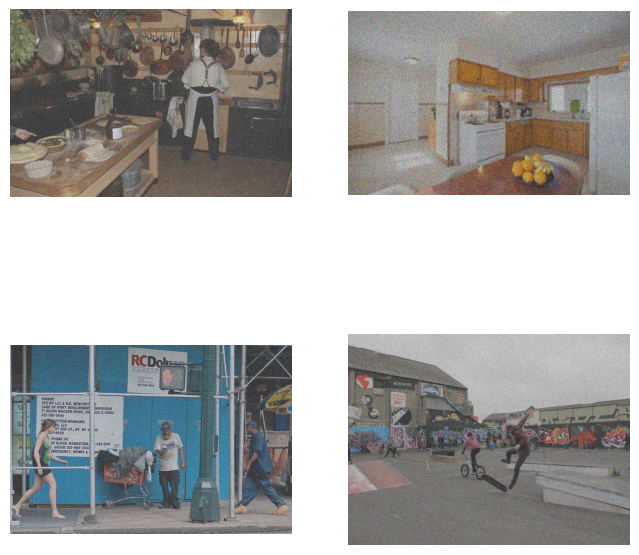

In [17]:
# CHECK: Stochastic perturbed dataset sanity
sanity_images, _ = next(iter(test_loader))

samples = [sanity_images[i] for i in range(4)]
noisy_samples = []

for sample in samples:
    # Inject stochastic perturbation
    noisy_tensor = generate_one_noisy_image(sample, intensity=0.1, noise_type='gaussian')
    
    noisy_samples.append(noisy_tensor)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    ax.imshow(noisy_samples[i].permute(1,2,0), cmap='gray')
    ax.axis('off')

plt.show()

# . Model

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## .. Golden model

In [19]:
# G. model preparation
# 골든 모델 준비

G_model = fasterrcnn_resnet50_fpn_v2(weights='COCO_V1',
                                   num_classes=91)
G_model = G_model.to(device)                             

### ... Label generation

In [20]:
def label_filtering(boxes, labels, scores, s_thr=0.5, n_thr=0.5):
    # Score filtering
    high_score_idxs = scores > s_thr
    filtered_boxes = boxes[high_score_idxs]
    filtered_scores = scores[high_score_idxs]
    filtered_labels = labels[high_score_idxs]
    
    # NMS filtering
    keep = nms(filtered_boxes, filtered_scores, n_thr)
    nms_boxes = filtered_boxes[keep]
    nms_scores = filtered_scores[keep]
    nms_labels = filtered_labels[keep]

    if len(keep) == 0:
        return (False, None, None, None)
    
    return (True, nms_labels, nms_boxes, nms_scores)       

In [21]:
def label_generation(model, data_loader, device, perturb=False):
    model.eval()
    results = []

    score_threshold = 0.5 # NOTE: 인자로 받을 것
    nms_threshold = 0.5 # NOTE: 인자로 받을 것

    with torch.no_grad():
        for images, targets in data_loader:
            # Inject noise
            if( perturb ):
                images = list(generate_one_noisy_image(image, intensity=0.8, noise_type='gaussian') for image in images)
            
            # Transfer to GPU
            images = list(image.to(device) for image in images)
            
            # Predict
            outputs = model(images)

            # Convert output to COCO evaluation format
            for i, output in enumerate(outputs):
                image_id = targets[i]['image_id'].item()
                boxes = output['boxes']
                labels = output['labels']
                scores = output['scores']

                # Convert bbox format from XYXY to XYWH
                boxes[:, 2:] -= boxes[:, :2]

                flag, labels, boxes, scores = label_filtering(
                    boxes, labels, scores, score_threshold, nms_threshold)
                if flag:
                    for label, box, score in zip(labels, boxes, scores):
                        result = {
                            'image_id': int(image_id),
                            'category_id': int(label),
                            'bbox': box.tolist(),
                            'score': float(score),
                        }
                        results.append(result)
                else:
                    continue
    return results

In [22]:
# Generate label for L. m.
results_g = label_generation(G_model, sample_loaders[0], device, perturb=True)

/home/hwkang/jupyter/venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [23]:
predicted_label_dataset = PredictedLabelDataset(path_train, path_file_ann_train, results_g, transform)

loading annotations into memory...
Done (t=9.01s)
creating index...
index created!


In [24]:
predicted_label_loader = DataLoader(predicted_label_dataset, batch_size=8, shuffle=False, collate_fn=utils.collate_fn)

## .. Light-weight model

In [25]:
# L. model preparation
# 경량 모델 준비

L_model = fasterrcnn_mobilenet_v3_large_320_fpn(weights='COCO_V1',
                                   num_classes=91)
L_model = L_model.to(device)

### ... Training

In [26]:
# Setup hyperparameters
# 하이퍼파라미터 설정

params = [p for p in L_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)
num_epochs = 3

# NOTE: 위 파라미터들은 정규 프로그램 구현 시 옵션 처리

In [27]:
# Training loop
# 훈련 루프
for epoch in range(num_epochs):
    engine.train_one_epoch(L_model, optimizer, sample_loaders[0], device, epoch, print_freq=500)
    lr_scheduler.step()
    #engine.evaluate(L_model, split_valid_loader, device=device)

/home/hwkang/jupyter/venv/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: [0]  [   0/2958]  eta: 0:21:34  lr: 0.000010  loss: 0.4560 (0.4560)  loss_classifier: 0.1815 (0.1815)  loss_box_reg: 0.2604 (0.2604)  loss_objectness: 0.0084 (0.0084)  loss_rpn_box_reg: 0.0056 (0.0056)  time: 0.4378  data: 0.0244  max mem: 3455
Epoch: [0]  [ 500/2958]  eta: 0:04:30  lr: 0.002507  loss: 0.7392 (0.6477)  loss_classifier: 0.2872 (0.2703)  loss_box_reg: 0.2988 (0.2751)  loss_objectness: 0.0575 (0.0612)  loss_rpn_box_reg: 0.0341 (0.0411)  time: 0.0949  data: 0.0206  max mem: 3455
Epoch: [0]  [1000/2958]  eta: 0:03:06  lr: 0.005000  loss: 0.6141 (0.6630)  loss_classifier: 0.2670 (0.2788)  loss_box_reg: 0.2557 (0.2798)  loss_objectness: 0.0470 (0.0622)  loss_rpn_box_reg: 0.0272 (0.0422)  time: 0.0926  data: 0.0164  max mem: 3455
Epoch: [0]  [1500/2958]  eta: 0:02:21  lr: 0.005000  loss: 0.7042 (0.6736)  loss_classifier: 0.3028 (0.2862)  loss_box_reg: 0.2962 (0.2817)  loss_objectness: 0.0664 (0.0630)  loss_rpn_box_reg: 0.0316 (0.0427)  time: 0.0986  data: 0.0197  max me

# . Evaluation

In [28]:
def coco_evaluation(ann_file, results):
    coco_gt = COCO(ann_file)
    coco_dt = coco_gt.loadRes(results)
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

# NOTE: 유틸리티 라이브러리에 추가할 것!

In [29]:
# L. m. on test d.
results_l = label_generation(L_model, test_loader, device, perturb=False)

In [30]:
with open('result_l.json', 'w') as f:
    json.dump(results_l, f)

coco_evaluation(path_file_ann_valid, 'result_l.json')

loading annotations into memory...
Done (t=2.19s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.10s).
Accumulating evaluation results...
DONE (t=1.21s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.136
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.234
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.143
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.112
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.276
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.135
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

# . Visualization

In [31]:
def draw_boxes(image, boxes, color):
    draw = ImageDraw.Draw(image)
    for box in boxes:
        draw.rectangle(box, outline=color, width=3)

def show_image_with_boxes(image, pred_boxes, true_boxes, green=True, red=True):
    image = transforms.ToPILImage()(image).convert("RGB")
    plt.figure(figsize=(10, 10))
    if red:
        draw_boxes(image, pred_boxes, color='red')
    if green:
        draw_boxes(image, true_boxes, color='green')

    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [32]:
#show_image_with_boxes(image, None, de_boxes.tolist(), green=True, red=True)